# Proyecto Final - Machine Learning
## Parte 1: Análisis Exploratorio y Preprocesamiento

**Estudiante:** Estanislao

**Objetivo:** Predecir características de vuelo a vela basándose en condiciones meteorológicas ERA5

## Setup Inicial

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Módulos del proyecto
from utils import (
    load_dataset,
    check_data_consistency,
    identify_useless_features,
    split_train_val_test,
    check_class_balance,
    print_consistency_report,
    print_useless_features_report
)

from analisis_exploratorio import (
    get_basic_statistics,
    analyze_target_distributions,
    compute_correlation_matrix,
    find_high_correlations,
    analyze_feature_importance_by_correlation,
    detect_outliers_multiple_methods,
    get_feature_value_ranges,
    print_target_analysis
)

from visualizaciones import (
    setup_plotting_style,
    plot_missing_values,
    plot_target_distributions,
    plot_feature_distributions,
    plot_correlation_matrix,
    plot_correlation_with_target,
    plot_scatter_matrix_with_target,
    plot_boxplots_by_class,
    plot_class_distribution,
    create_visualization_directory
)

from preprocessing import PreprocessingPipeline

# Setup plotting
setup_plotting_style()
vis_dir = create_visualization_directory()

# Configuración pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("Módulos cargados")

✓ Módulos cargados correctamente


---
## 1. Carga de Datos

In [2]:
# Cargar dataset completo
df = load_dataset('data/processed/dataset_completo.csv')

print(f"\nShape: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Dataset cargado: 387 filas × 96 columnas

Shape: (387, 96)

Primeras filas:


,fecha,pilot,glider,competition_id,altura_max_m,altura_min_m,altura_despegue_m,altura_aterrizaje_m,ganancia_altura_m,rango_altura_m,duracion_min,duracion_horas,distancia_km,velocidad_promedio_kmh,lat_despegue,lon_despegue,hora_despegue,hora_despegue_decimal,num_gps_fixes,frecuencia_muestreo_seg,num_termicas,intensidad_termicas_mean_ms,intensidad_termicas_max_ms,intensidad_termicas_min_ms,intensidad_termicas_std_ms,altura_base_termicas_mean_m,altura_tope_termicas_mean_m,altura_base_termicas_min_m,altura_tope_termicas_max_m,ganancia_por_termica_mean_m,ganancia_por_termica_max_m,duracion_termica_mean_seg,duracion_termica_max_seg,hora_primera_termica,hora_ultima_termica,dispersion_termicas_lat,dispersion_termicas_lon,tiempo_en_termicas_min,tiempo_en_planeo_min,porcentaje_tiempo_termicas,tasa_ascenso_mean_ms,tasa_descenso_mean_ms,bearing_change_mean_deg,bearing_change_max_deg,bearing_change_std_deg,ground_speed_mean_kmh,ground_speed_max_kmh,ground_speed_min_kmh,ground_speed_std_kmh,hora_inicio_decimal,hora_fin_decimal,altura_mean_manana_m,altura_mean_mediodia_m,altura_mean_tarde1_m,altura_mean_tarde2_m,lat_min,lat_max,lon_min,lon_max,lat_centro,lon_centro,rango_lat_deg,rango_lon_deg,distancia_max_despegue_km,area_vuelo_km2,altura_std_m,altura_cv,cambio_altura_mean_m,cambio_altura_std_m,filename,flight_id,solar_rad_total,solar_rad_max,precipitation_total,temp_2m_max,temp_2m_min,temp_2m_mean,cloud_cover_mean,wind_u_mean,wind_v_mean,pressure_mean,boundary_layer_height_mean,boundary_layer_height_max,cape_mean,cape_max,skin_temp_max,skin_temp_min,skin_temp_mean,temp_differential,wind_speed_mean,calidad_dia,fecha_dt,mes,dia_año,dia_semana,año
0,2024-01-08,Miguel Serrano,ASW-20,AJ,1282,98,107,101,1181,1184,148.100,2.470,284.200,115.200,-31.276,-61.508,16:01:00,16.030,4863,1.000,45,2.410,8.000,1.270,0.550,910.000,952.000,99,1263,42.000,414,18.000,150.000,16.110,18.120,0.118,0.218,52.900,95.200,35.700,2.470,-1.910,23.800,359.400,60.600,116.800,196.800,0.000,25.700,16.030,18.490,0,0,0.000,910.000,-31.328,-30.930,-62.133,-61.494,-31.207,-61.854,0.398,0.639,57.600,2600.600,238.500,0.287,-0.000,5.700,2024-01-08 Mauro Jusco 358357.igc,IGC_0006,6468290.560,1079.147,3072.963,31.286,14.077,23.583,0.449,1.037,0.039,998.976,710.428,2717.361,424.785,2025.125,40.258,15.196,26.403,17.208,1.038,Regular,2024-01-08,1,8,0,2024
1,2024-01-08,Miguel Angel Serrano,401 Kestrel 19m,AT,1348,111,114,117,1234,1237,153.700,2.560,271.500,106.000,-31.276,-61.508,15:52:00,15.880,9219,1.000,107,2.330,13.000,1.090,0.720,927.000,969.000,118,1348,42.000,196,19.000,74.000,15.900,18.240,0.110,0.181,58.100,95.600,37.800,2.240,-1.920,8.400,356.600,35.900,115.700,172.900,0.000,26.700,15.880,18.440,0,0,0.000,908.000,-31.309,-30.930,-62.112,-61.478,-31.187,-61.732,0.379,0.634,55.700,2451.500,226.800,0.249,0.000,2.200,2024-01-08 Miguel Ángel Serrano 358353.igc,IGC_0078,6468290.560,1079.147,3072.963,31.286,14.077,23.583,0.449,1.037,0.039,998.976,710.428,2717.361,424.785,2025.125,40.258,15.196,26.403,17.208,1.038,Regular,2024-01-08,1,8,0,2024
2,2024-01-12,Unknown,Unknown,NaN,1471,110,111,111,1360,1361,160.500,2.670,318.300,119.000,-31.286,-61.512,16:23:00,16.390,5140,1.000,71,3.510,64.000,-8.080,3.920,1012.000,1056.000,122,1442,45.000,260,17.000,101.000,16.470,18.880,0.205,0.079,59.200,101.300,36.900,3.550,-3.850,22.600,357.400,58.100,117.200,245.600,0.000,31.100,16.390,19.060,0,0,0.000,814.000,-31.573,-30.846,-61.591,-61.300,-31.165,-61.466,0.727,0.291,52.600,2162.900,233.500,0.234,0.000,13.000,2024-01-12 Mauro Jusco 359020.igc,IGC_0347,7176294.400,1089.778,613.816,32.292,8.133,22.157,0.300,-2.405,-1.685,1006.316,765.933,2582.021,82.022,2197.375,39.216,8.190,25.917,24.159,2.936,Regular,2024-01-12,1,12,4,2024
3,2024-01-12,Miguel Angel Serrano,401 Kestrel 19m,AT,1262,115,127,126,1136,1147,156.100,2.600,260.000,100.000,-31.286,-61.512,16:15:00,16.260,9360,1.000,91,2.130,9.000,1.090,0.590,879.000,915.000,129,1242,36.000,172,17.000,60.000,16.280,18.610,0.156,0.028,58.500,97.600,37.500,2.

Podemos apreciar que el dataset cuenta con una gran cantidad de features. Esto nos podria generar problemas a futuro con los modelos, por lo tanto vamos a controlar o buscar mitigar esto.

In [3]:
# Información general
print("Información del dataset:")
df.info()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 96 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   fecha                        387 non-null    object 
 1   pilot                        387 non-null    object 
 2   glider                       387 non-null    object 
 3   competition_id               253 non-null    object 
 4   altura_max_m                 387 non-null    int64  
 5   altura_min_m                 387 non-null    int64  
 6   altura_despegue_m            387 non-null    int64  
 7   altura_aterrizaje_m          387 non-null    int64  
 8   ganancia_altura_m            387 non-null    int64  
 9   rango_altura_m               387 non-null    int64  
 10  duracion_min                 387 non-null    float64
 11  duracion_horas               387 non-null    float64
 12  distancia_km                 387 non-null    float64


---
## 2. Chequeos de Consistencia

In [4]:
# Ejecutar chequeos de consistencia
consistency_report = check_data_consistency(df)
print_consistency_report(consistency_report)

REPORTE DE CONSISTENCIA DE DATOS

1. DUPLICADOS:
   Total: 0
   Porcentaje: 0.00%

2. VALORES FALTANTES:
   Columnas con valores faltantes: 5

   Top 10:
   - competition_id: 134.0 (34.63%)
   - ground_speed_std_kmh: 11.0 (2.84%)
   - intensidad_termicas_std_ms: 2.0 (0.52%)
   - dispersion_termicas_lat: 2.0 (0.52%)
   - dispersion_termicas_lon: 2.0 (0.52%)

3. TIPOS DE DATOS:
   - float64: 70 columnas
   - int64: 17 columnas
   - object: 9 columnas

4. FEATURES CON ALTA CARDINALIDAD (posibles IDs):
   - altura_max_m: 347 valores únicos
   - ganancia_altura_m: 349 valores únicos
   - rango_altura_m: 347 valores únicos
   - duracion_min: 355 valores únicos
   - duracion_horas: 258 valores únicos
   - distancia_km: 378 valores únicos
   - velocidad_promedio_kmh: 294 valores únicos
   - lat_despegue: 260 valores únicos
   - lon_despegue: 251 valores únicos
   - hora_despegue_decimal: 219 valores únicos
   - num_gps_fixes: 381 valores únicos
   - num_termicas: 199 valores únicos
   - altura

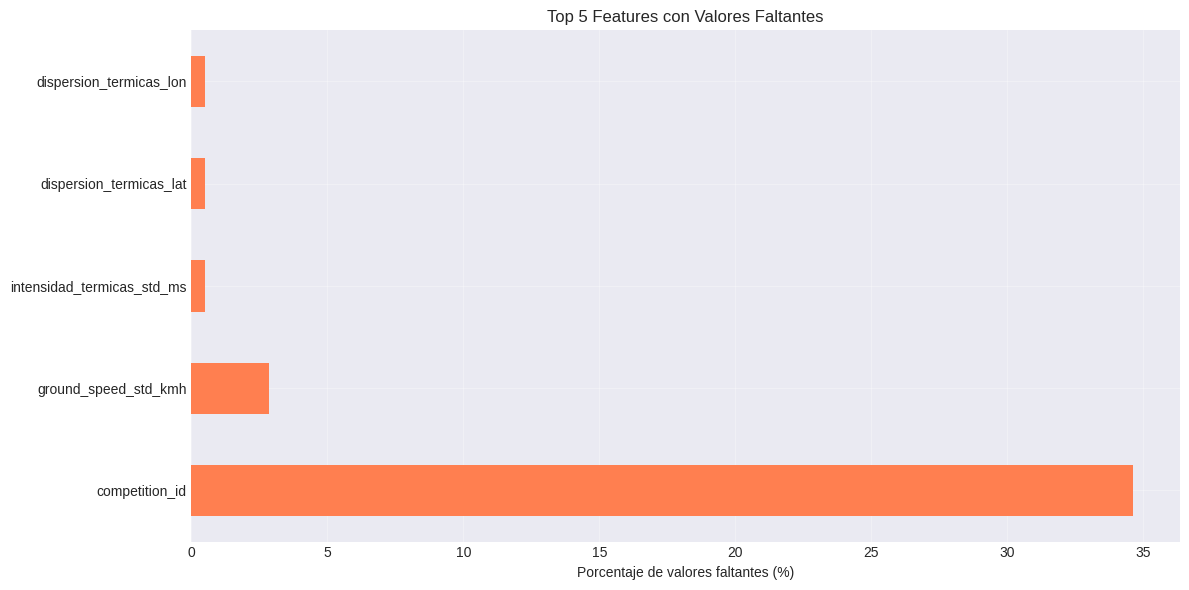

In [5]:
# Visualizar valores faltantes
if len(consistency_report['missing_values'][consistency_report['missing_values']['count'] > 0]) > 0:
    plot_missing_values(
        consistency_report['missing_values'],
        save_path=f'{vis_dir}/01_valores_faltantes.png'
    )

### 2.1 Identificación de Features Inútiles

In [6]:
# Identificar features que no aportan valor predictivo
useless_features = identify_useless_features(df)
print_useless_features_report(useless_features)


IDENTIFICACIÓN DE FEATURES SIN VALOR PREDICTIVO

1. IDENTIFICADORES (IDs):
   - distancia_km
   - num_gps_fixes
   - dispersion_termicas_lon
   - lat_min
   - lat_max
   - lon_min
   - lon_max
   - lat_centro
   - lon_centro
   - rango_lat_deg
   - rango_lon_deg
   - area_vuelo_km2
   - filename
   - flight_id

2. ALTA CARDINALIDAD (categóricas con muchos valores):
   - fecha
   - pilot
   - glider
   - hora_despegue
   - filename
   - flight_id
   - fecha_dt

3. CONSTANTES:
   - altura_mean_manana_m
   - altura_mean_mediodia_m

4. CASI CONSTANTES (>95% mismo valor):
   - ground_speed_min_kmh
   - altura_mean_tarde1_m
   - cambio_altura_mean_m

5. RECOMENDADAS PARA ELIMINAR:
   Total: 20
   - distancia_km
   - num_gps_fixes
   - dispersion_termicas_lon
   - ground_speed_min_kmh
   - altura_mean_manana_m
   - altura_mean_mediodia_m
   - altura_mean_tarde1_m
   - lat_min
   - lat_max
   - lon_min
   - lon_max
   - lat_centro
   - lon_centro
   - rango_lat_deg
   - rango_lon_deg
   - are

**Decisión:** Eliminaremos las features recomendadas (IDs, constantes, etc.) antes del modelado.

---
## 3. Estadísticas Descriptivas

In [7]:
# Estadísticas básicas
numeric_stats, categorical_stats = get_basic_statistics(df)

print("Estadísticas de features numéricas:")
print(numeric_stats)

Estadísticas de features numéricas:
       altura_max_m  altura_min_m  altura_despegue_m  altura_aterrizaje_m  \
count       387.000       387.000            387.000              387.000   
mean       2231.612       137.276            187.264              150.630   
std        3417.991        59.337            233.908              119.341   
min         560.000         2.000             21.000               24.000   
25%        1702.000        99.000            104.000              102.000   
50%        2009.000       118.000            148.000              123.000   
75%        2279.000       196.000            203.000              200.500   
max       64500.000       212.000           2014.000             1733.000   

       ganancia_altura_m  rango_altura_m  duracion_min  duracion_horas  \
count            387.000         387.000       387.000         387.000   
mean            2091.413        2094.336       197.438           3.291   
std             3410.688        3410.611        

In [8]:
# Estadísticas de features categóricas
if len(categorical_stats) > 0:
    print("\nEstadísticas de features categóricas:")
    print(categorical_stats)


Estadísticas de features categóricas:
          feature  n_unique                        most_common  \
0           fecha        91                         2025-01-11   
1           pilot        56                            Unknown   
2          glider        52                          PW-5 Smyk   
3  competition_id        47                                 AF   
4   hora_despegue       159                           15:51:00   
5        filename       387  2024-01-08 Mauro Jusco 358357.igc   
6       flight_id       387                           IGC_0000   
7     calidad_dia         4                              Bueno   
8        fecha_dt        91                         2025-01-11   

   most_common_freq  
0                27  
1                66  
2                30  
3                17  
4                 7  
5                 1  
6                 1  
7               248  
8                27  


---
## 4. Análisis de Variables Target

In [9]:
# Definir targets
targets_regresion = ['altura_max_m', 'duracion_min', 'distancia_km']
target_clasificacion = 'calidad_dia'

print(f"Targets de regresión: {targets_regresion}")
print(f"Target de clasificación: {target_clasificacion}")

Targets de regresión: ['altura_max_m', 'duracion_min', 'distancia_km']
Target de clasificación: calidad_dia


In [10]:
# Análisis detallado de targets
target_analysis = analyze_target_distributions(df, targets_regresion)
print_target_analysis(target_analysis)

ANÁLISIS DE VARIABLES TARGET

altura_max_m:
  Observaciones: 387
  Faltantes: 0
  Media: 2231.61
  Mediana: 2009.00
  Std: 3417.99
  Rango: [560.00, 64500.00]
  Asimetría: 16.432
  Curtosis: 291.268
  Normalidad (Shapiro-Wilk p-value): 0.0000
    → NO Normal

duracion_min:
  Observaciones: 387
  Faltantes: 0
  Media: 197.44
  Mediana: 202.00
  Std: 72.81
  Rango: [12.30, 404.20]
  Asimetría: -0.214
  Curtosis: 0.055
  Normalidad (Shapiro-Wilk p-value): 0.0020
    → NO Normal

distancia_km:
  Observaciones: 387
  Faltantes: 0
  Media: 394.19
  Mediana: 395.10
  Std: 171.90
  Rango: [12.10, 899.00]
  Asimetría: 0.020
  Curtosis: -0.181
  Normalidad (Shapiro-Wilk p-value): 0.0125
    → NO Normal


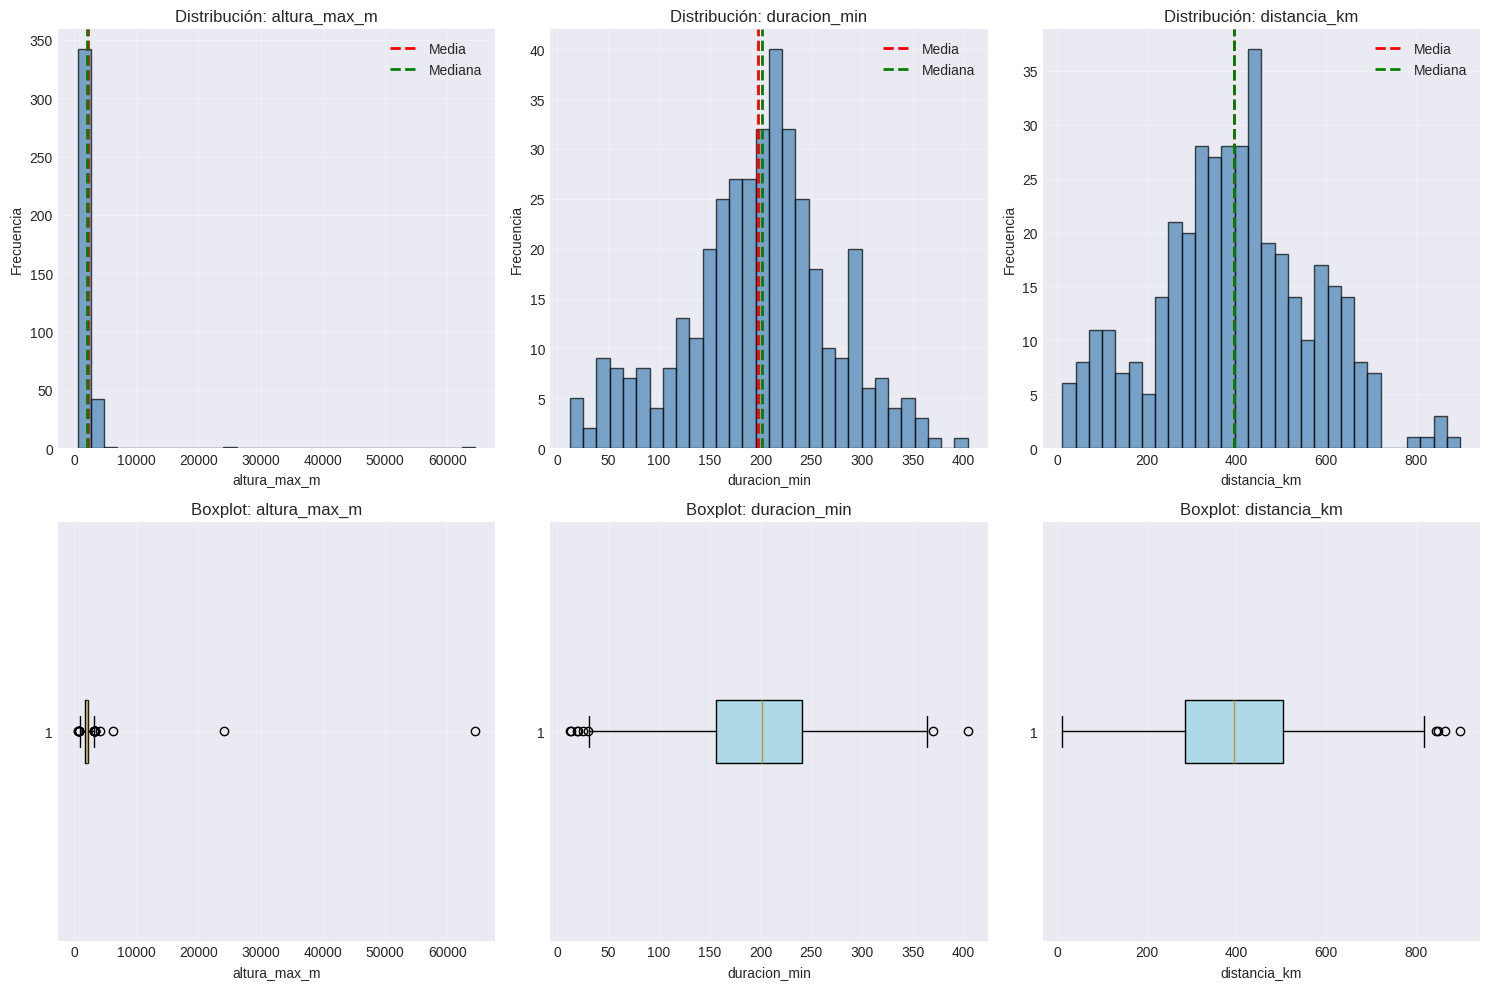

In [11]:
# Visualizar distribuciones de targets
plot_target_distributions(
    df,
    targets_regresion,
    save_path=f'{vis_dir}/02_distribucion_targets.png'
)

**Observaciones sobre normalidad:**
- Las distribuciones muestran características no-normales
- Esto justifica el uso de RobustScaler en lugar de StandardScaler

---
## 5. Análisis de Desbalanceo de Clases

In [12]:
# Analizar balance de clases
balance_info = check_class_balance(df, target_clasificacion)

print("="*70)
print("ANÁLISIS DE DESBALANCEO DE CLASES")
print("="*70)
print(f"\nConteos por clase:")
print(balance_info['counts'])
print(f"\nPorcentajes:")
print(balance_info['percentages'])
print(f"\nRatio de desbalanceo: {balance_info['imbalance_ratio']:.2f}")
print(f"Estado: {balance_info['balance_status']}")

ANÁLISIS DE DESBALANCEO DE CLASES

Conteos por clase:
calidad_dia
Bueno        248
Excelente     69
Regular       60
Malo          10
Name: count, dtype: int64

Porcentajes:
calidad_dia
Bueno       64.083
Excelente   17.829
Regular     15.504
Malo         2.584
Name: proportion, dtype: float64

Ratio de desbalanceo: 24.80
Estado: Fuertemente desbalanceado


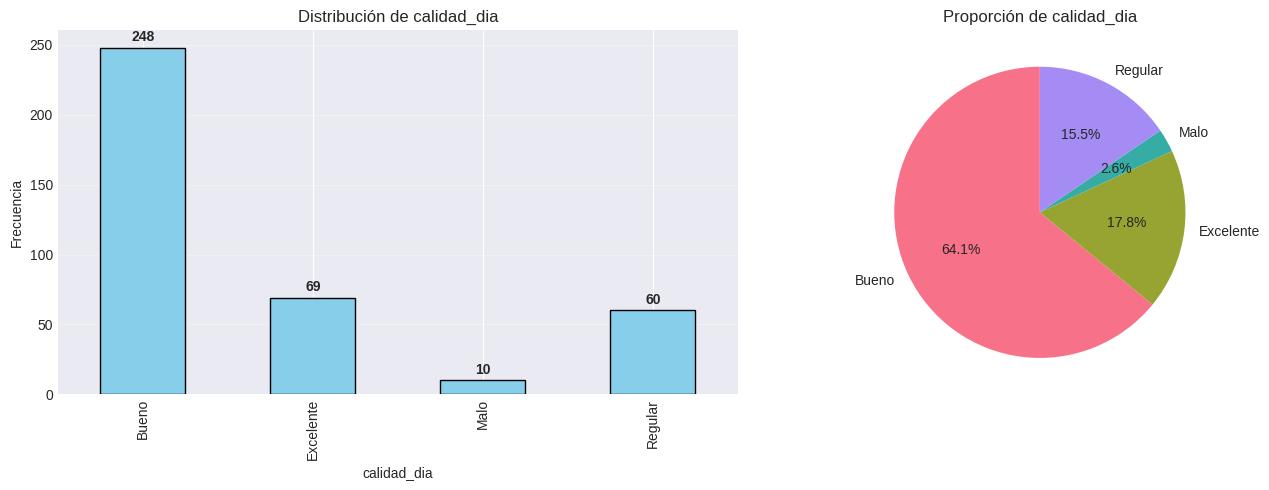

In [13]:
# Visualizar distribución de clases
plot_class_distribution(
    df,
    target_clasificacion,
    save_path=f'{vis_dir}/03_distribucion_clases.png'
)

**Decisión sobre desbalanceo:**
- Si el desbalanceo es moderado-fuerte, considerar técnicas como SMOTE o class weights en el modelado

---
## 6. Análisis de Distribuciones de Features

### 6.1 Features Meteorológicas

In [14]:
# Identificar features meteorológicas
features_meteo = [
    'temp_2m_max', 'temp_2m_min', 'temp_2m_mean', 'temp_differential',
    'solar_rad_total', 'solar_rad_max',
    'cape_max', 'cape_mean',
    'boundary_layer_height_max', 'boundary_layer_height_mean',
    'wind_speed_mean', 'wind_u_mean', 'wind_v_mean',
    'cloud_cover_mean', 'pressure_mean', 'precipitation_total'
]
features_meteo = [f for f in features_meteo if f in df.columns]

print(f"Features meteorológicas identificadas: {len(features_meteo)}")

Features meteorológicas identificadas: 16


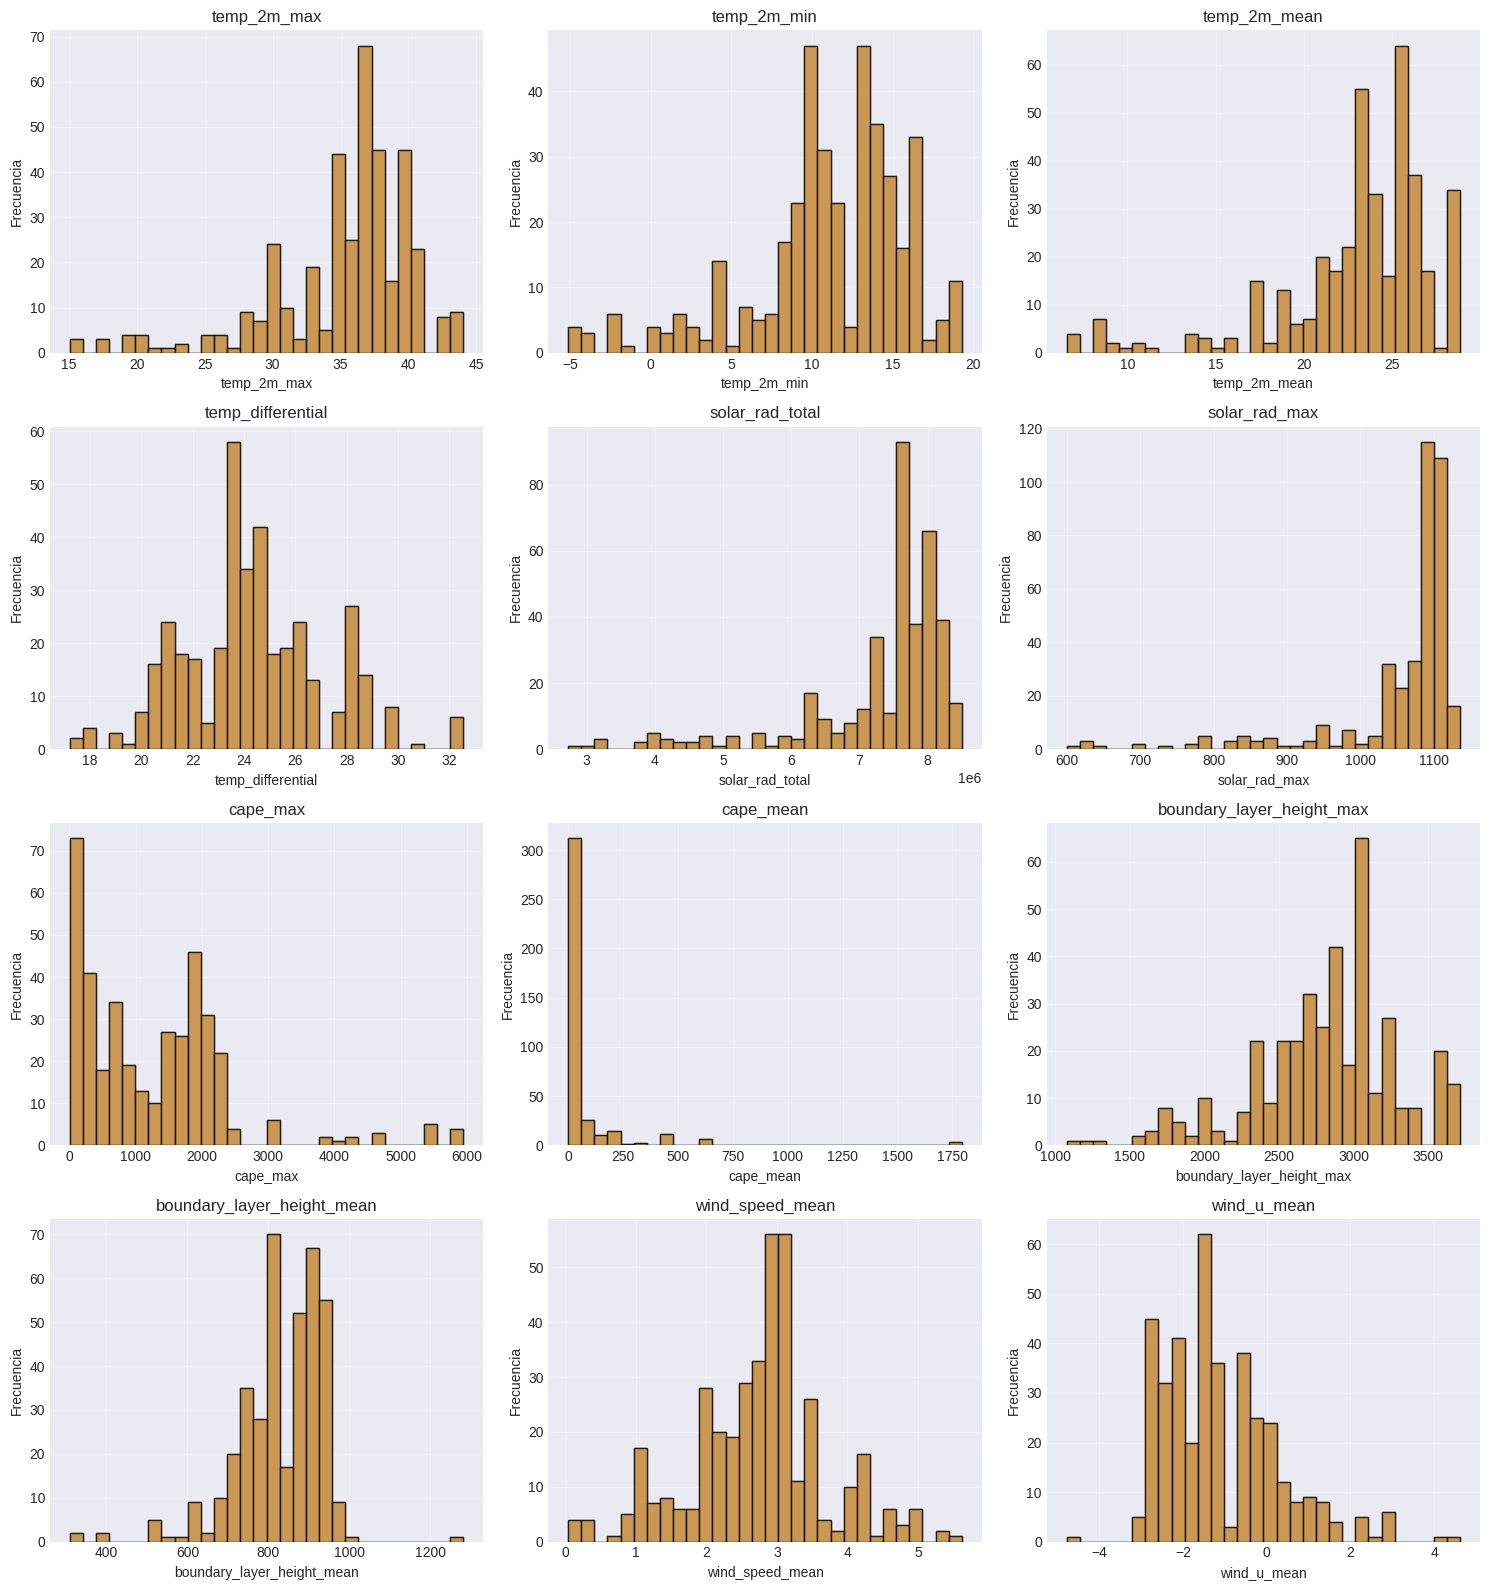

In [15]:
# Visualizar distribuciones meteorológicas
features_meteo_vis = features_meteo[:12]  # Primeras 12
plot_feature_distributions(
    df,
    features_meteo_vis,
    save_path=f'{vis_dir}/04_distribucion_meteo.png',
    n_cols=3
)

### 6.2 Features de Vuelo (IGC)

In [16]:
# Features clave de vuelo
features_vuelo = [
    'num_termicas', 'intensidad_termicas_mean_ms', 'duracion_termica_mean_seg',
    'ganancia_altura_m', 'velocidad_promedio_kmh', 'porcentaje_tiempo_termicas',
    'ground_speed_mean_kmh', 'bearing_change_mean_deg', 'altura_std_m'
]
features_vuelo = [f for f in features_vuelo if f in df.columns]

print(f"Features de vuelo seleccionadas: {len(features_vuelo)}")

Features de vuelo seleccionadas: 9


ValueError: supplied range of [77.6, inf] is not finite

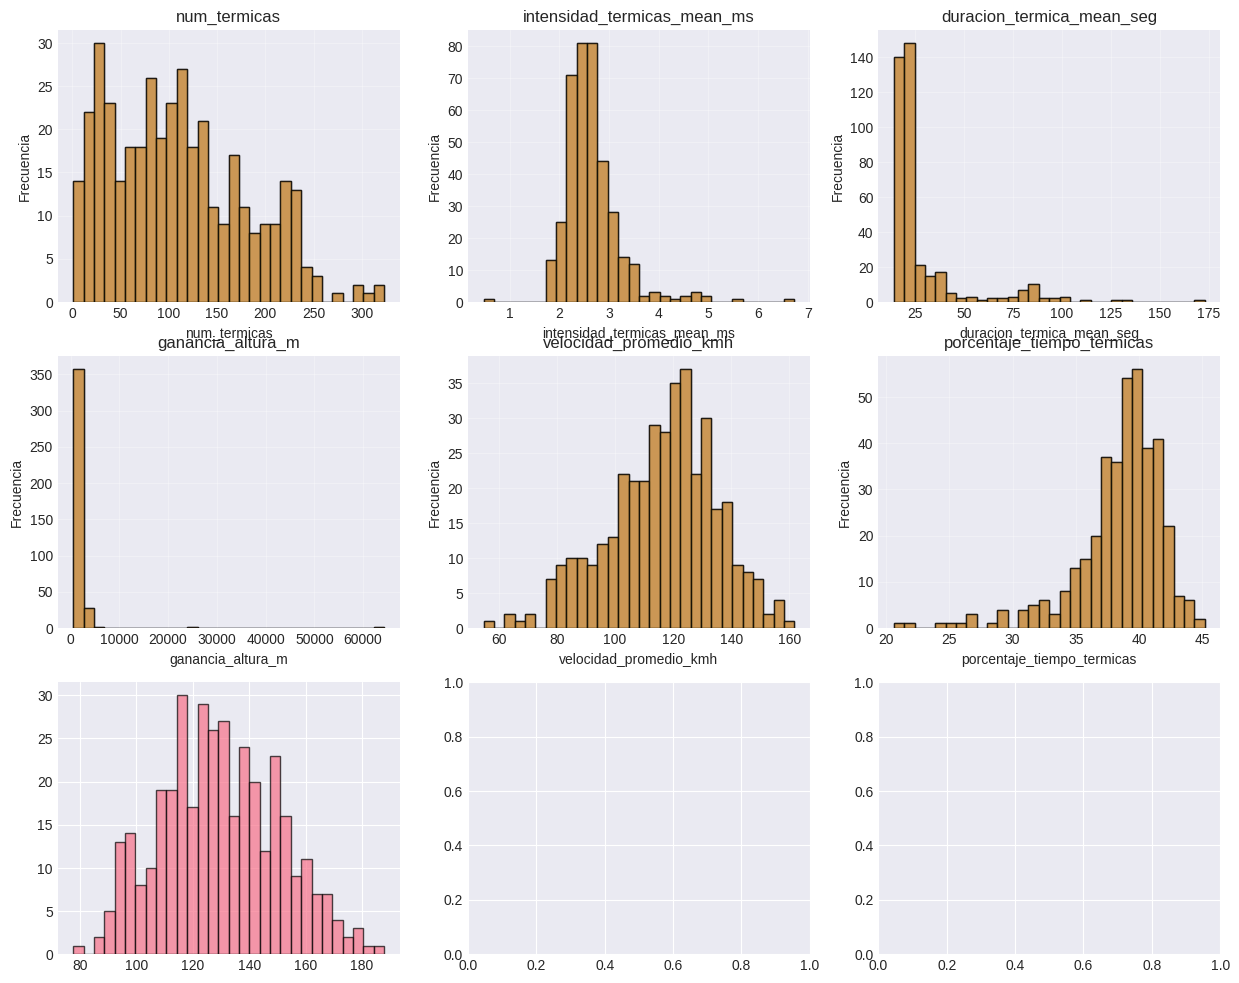

In [17]:
# Visualizar distribuciones de vuelo
plot_feature_distributions(
    df,
    features_vuelo,
    save_path=f'{vis_dir}/05_distribucion_vuelo.png',
    n_cols=3
)

---
## 7. Rangos de Features y Relación con Target

In [18]:
# Obtener rangos de todas las features numéricas
feature_ranges = get_feature_value_ranges(df)

print("Rangos de features (ordenadas por rango):")
print(feature_ranges.head(20))

Rangos de features (ordenadas por rango):
                        feature         min         max       range  \
41         ground_speed_max_kmh     146.200         inf         inf   
40        ground_speed_mean_kmh      77.600         inf         inf   
64              solar_rad_total 2728935.538 8503746.560 5774811.022   
0                  altura_max_m     560.000   64500.000   63940.000   
4             ganancia_altura_m     528.000   64299.000   63771.000   
5                rango_altura_m     532.000   64299.000   63767.000   
59               area_vuelo_km2       4.500   28228.600   28224.100   
13                num_gps_fixes     260.000   21228.000   20968.000   
66          precipitation_total       0.000   10720.131   10720.131   
77                     cape_max       1.625    5949.250    5947.625   
60                 altura_std_m     107.200    3293.500    3186.300   
23   altura_tope_termicas_max_m     556.000    3415.000    2859.000   
75    boundary_layer_height_max    

In [19]:
# Features con mayor variabilidad (alto coeficiente de variación)
high_cv = feature_ranges.sort_values('cv', ascending=False).head(15)
print("\nFeatures con mayor variabilidad (CV):")
print(high_cv[['feature', 'cv', 'mean', 'std']])


Features con mayor variabilidad (CV):
                       feature        cv     mean      std
46        altura_mean_manana_m       inf    0.000    0.000
47      altura_mean_mediodia_m       inf    0.000    0.000
18  intensidad_termicas_min_ms 13152.744    0.034    4.496
42        ground_speed_min_kmh  5048.650    0.018    0.913
48        altura_mean_tarde1_m   824.083   14.731  121.398
63         cambio_altura_std_m   706.889   12.336   87.199
66         precipitation_total   335.072  272.950  914.577
76                   cape_mean   270.109   70.792  191.214
4            ganancia_altura_m   163.081 2091.413 3410.688
5               rango_altura_m   162.849 2094.336 3410.611
17  intensidad_termicas_max_ms   155.111   26.313   40.815
0                 altura_max_m   153.162 2231.612 3417.991
2            altura_despegue_m   124.908  187.264  233.908
84                     dia_año   101.944  145.765  148.599
19  intensidad_termicas_std_ms    99.965    1.170    1.170


---
## 8. Análisis de Correlaciones

### 8.1 Matriz de Correlación Completa

In [20]:
# Calcular matriz de correlación COMPLETA
# Incluir TODAS las features numéricas
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Calculando matriz de correlación para {len(numeric_features)} features numéricas...")

corr_matrix_full = compute_correlation_matrix(df, features=numeric_features)
print(f"\nMatriz calculada: {corr_matrix_full.shape}")

Calculando matriz de correlación para 87 features numéricas...

Matriz calculada: (87, 87)


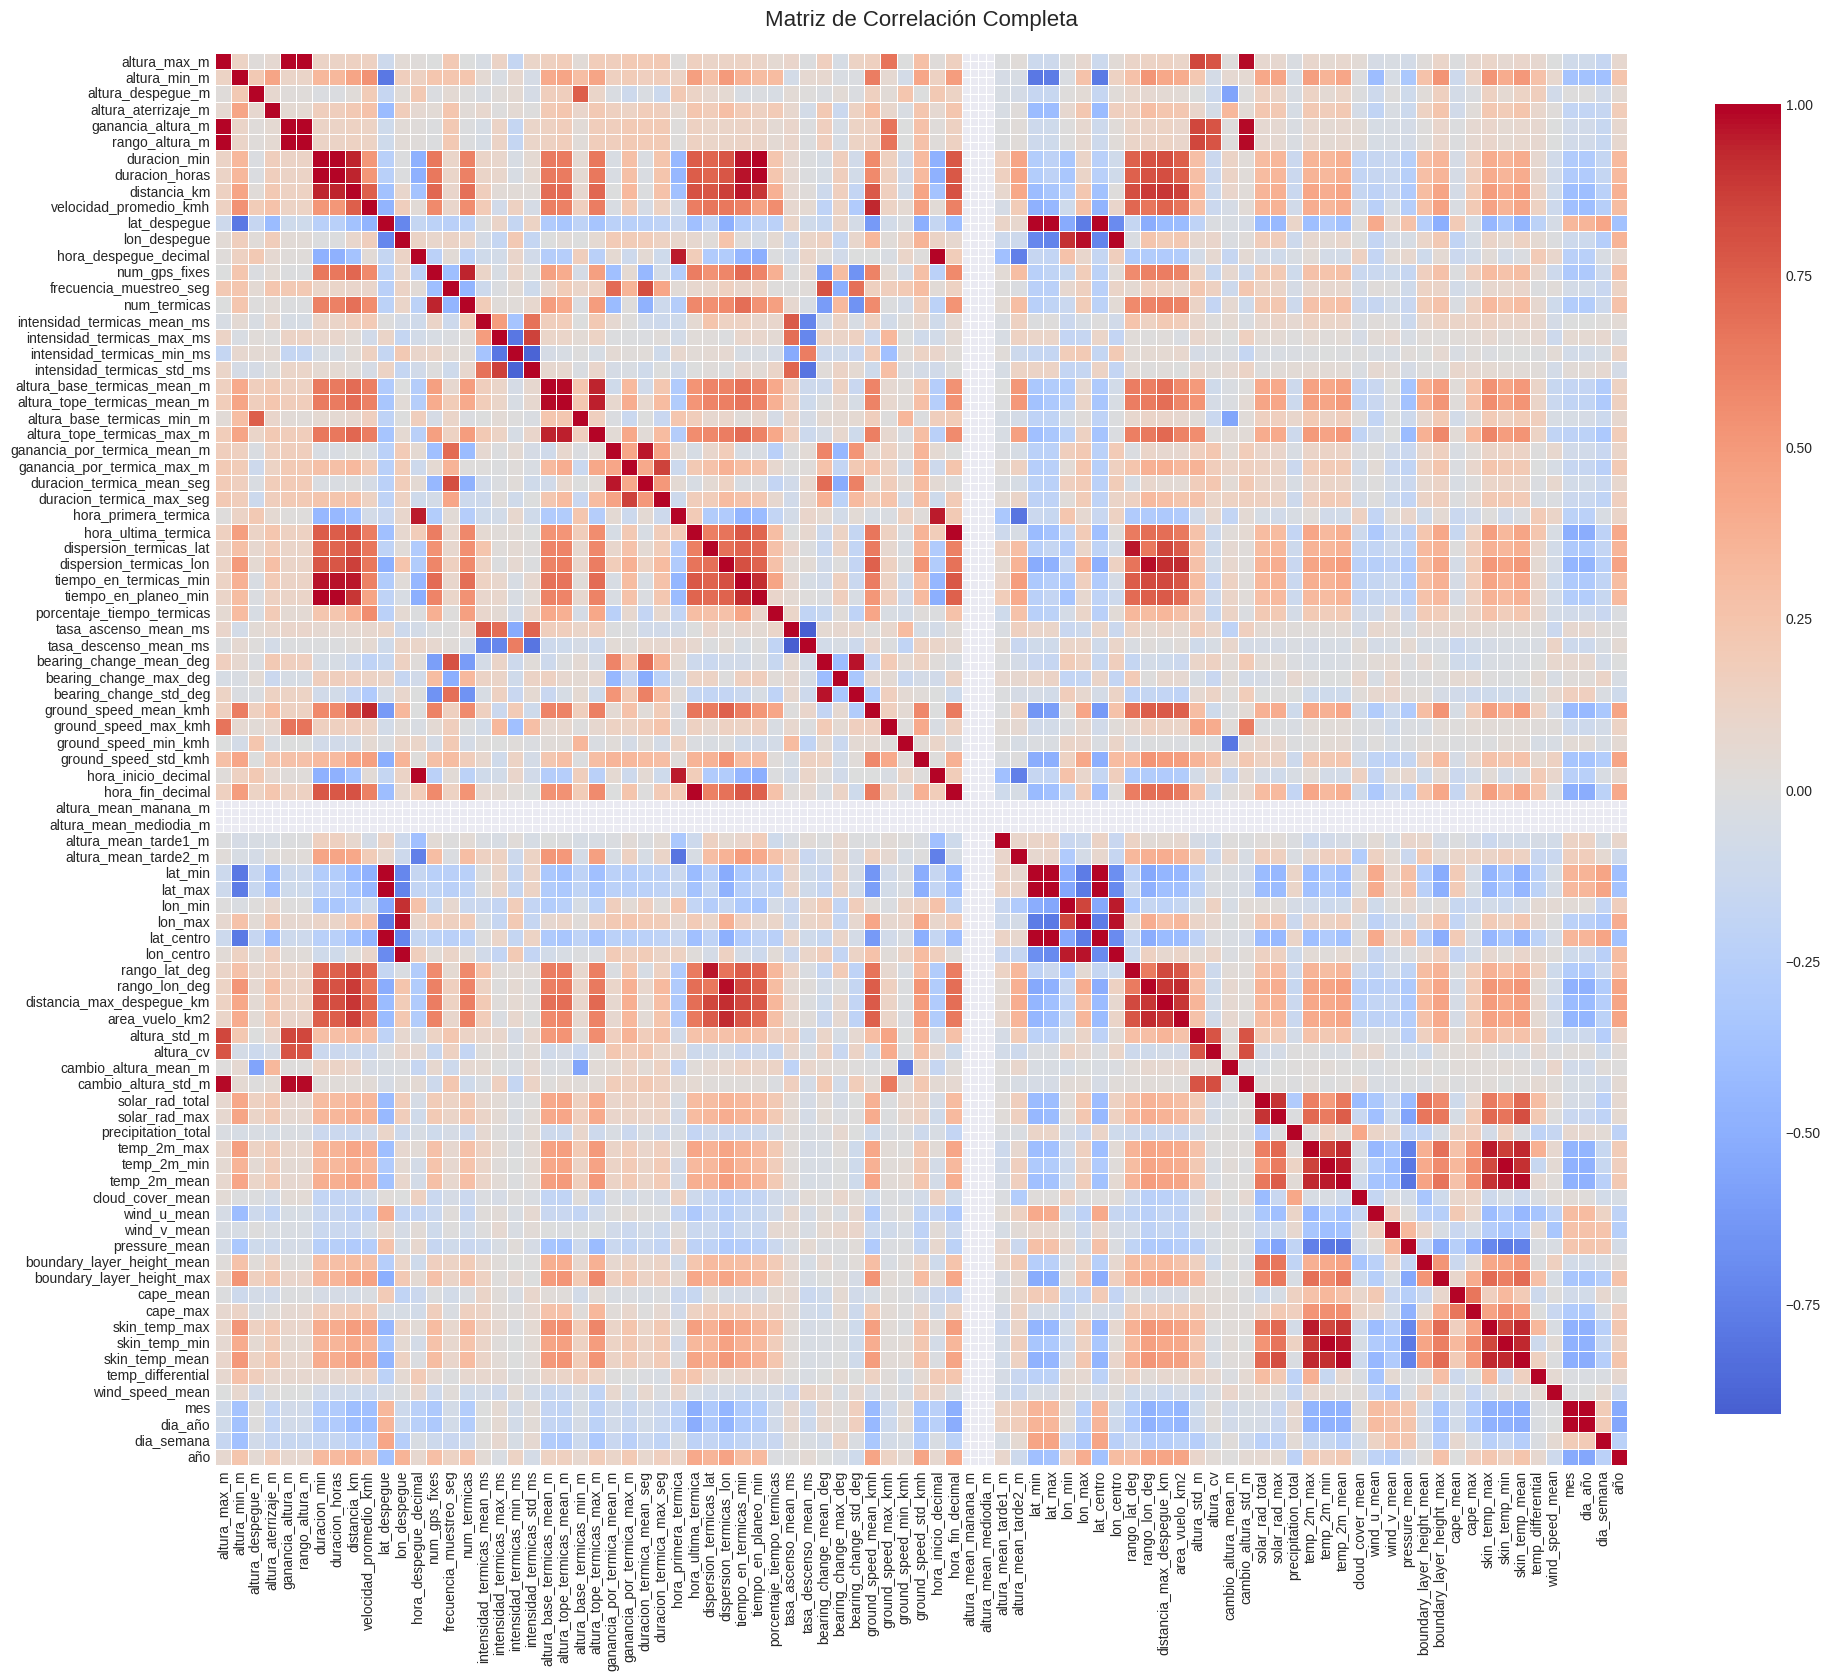

In [21]:
# Visualizar matriz completa
plot_correlation_matrix(
    corr_matrix_full,
    save_path=f'{vis_dir}/06_matriz_correlacion_completa.png',
    figsize=(20, 18),
    annot=False
)

### 8.2 Correlaciones Altas (Multicolinealidad)

In [22]:
# Identificar features altamente correlacionadas entre sí
high_corr_pairs = find_high_correlations(corr_matrix_full, threshold=0.8)

if len(high_corr_pairs) > 0:
    print("="*70)
    print("FEATURES ALTAMENTE CORRELACIONADAS (|r| >= 0.8)")
    print("="*70)
    print(f"\nEncontrados {len(high_corr_pairs)} pares:\n")
    print(high_corr_pairs.head(20))
    print("\n⚠️ Considerar eliminar una de cada par para reducir multicolinealidad")
else:
    print("✓ No se encontraron correlaciones muy altas (|r| >= 0.8)")

FEATURES ALTAMENTE CORRELACIONADAS (|r| >= 0.8)

Encontrados 88 pares:

                      feature_1                    feature_2  correlation
33        hora_despegue_decimal          hora_inicio_decimal        1.000
4             ganancia_altura_m               rango_altura_m        1.000
9                  duracion_min               duracion_horas        1.000
0                  altura_max_m            ganancia_altura_m        1.000
1                  altura_max_m               rango_altura_m        1.000
28                 lat_despegue                   lat_centro        0.999
59                      lat_min                   lat_centro        0.999
60                      lat_max                   lat_centro        0.999
87                          mes                      dia_año        0.999
26                 lat_despegue                      lat_min        0.998
27                 lat_despegue                      lat_max        0.998
58                      lat_min         

### 8.3 Features Correlacionadas con Targets

In [23]:
# Analizar importancia de features por correlación con cada target
feature_importance = analyze_feature_importance_by_correlation(
    df,
    targets_regresion,
    top_n=15
)

for target, importance in feature_importance.items():
    print(f"\n{'='*70}")
    print(f"TOP FEATURES CORRELACIONADAS CON {target}")
    print(f"{'='*70}")
    print(f"\nTop 15 (por valor absoluto):")
    print(importance['top_absolute'])


TOP FEATURES CORRELACIONADAS CON altura_max_m

Top 15 (por valor absoluto):
ganancia_altura_m             1.000
rango_altura_m                1.000
cambio_altura_std_m           0.980
altura_std_m                  0.842
altura_cv                     0.788
ground_speed_max_kmh          0.671
ground_speed_std_kmh          0.280
frecuencia_muestreo_seg       0.216
duracion_termica_max_seg      0.210
ganancia_por_termica_max_m    0.206
duracion_termica_mean_seg     0.198
altura_tope_termicas_mean_m   0.181
altura_tope_termicas_max_m    0.179
intensidad_termicas_min_ms    0.170
ganancia_por_termica_mean_m   0.167
Name: altura_max_m, dtype: float64

TOP FEATURES CORRELACIONADAS CON duracion_min

Top 15 (por valor absoluto):
duracion_horas                1.000
tiempo_en_planeo_min          0.987
tiempo_en_termicas_min        0.967
distancia_max_despegue_km     0.806
rango_lon_deg                 0.795
dispersion_termicas_lon       0.780
hora_fin_decimal              0.771
hora_ultima_termica

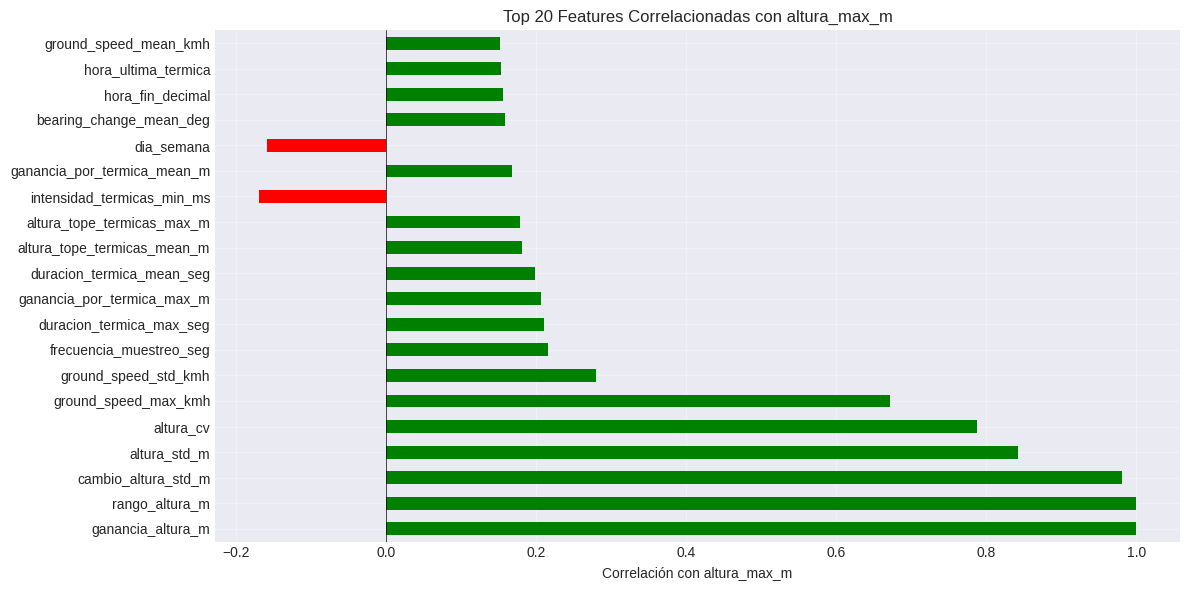

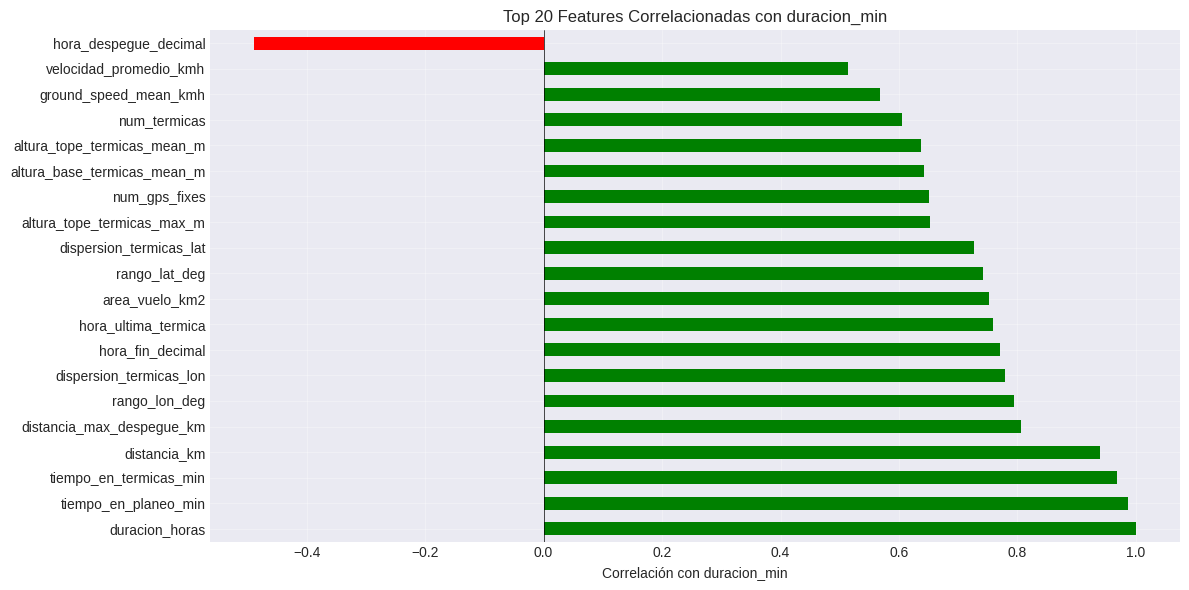

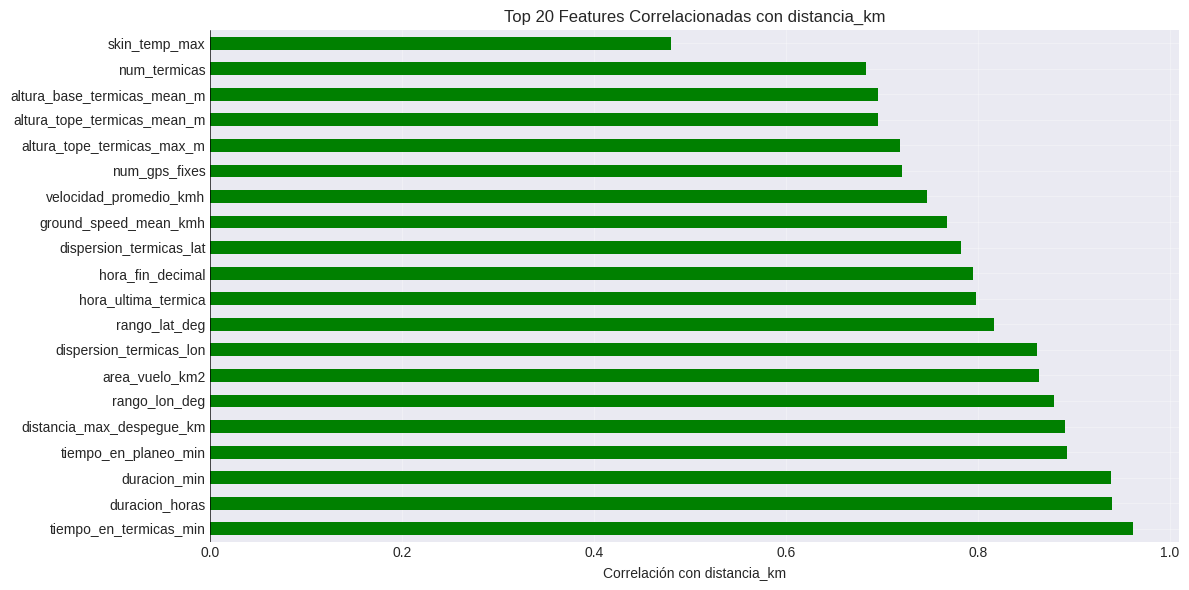

In [24]:
# Visualizar correlaciones con cada target
for target in targets_regresion:
    if target in df.columns:
        plot_correlation_with_target(
            df,
            target,
            top_n=20,
            save_path=f'{vis_dir}/07_correlacion_{target}.png'
        )

### 8.4 Scatter Plots: Features vs Targets

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

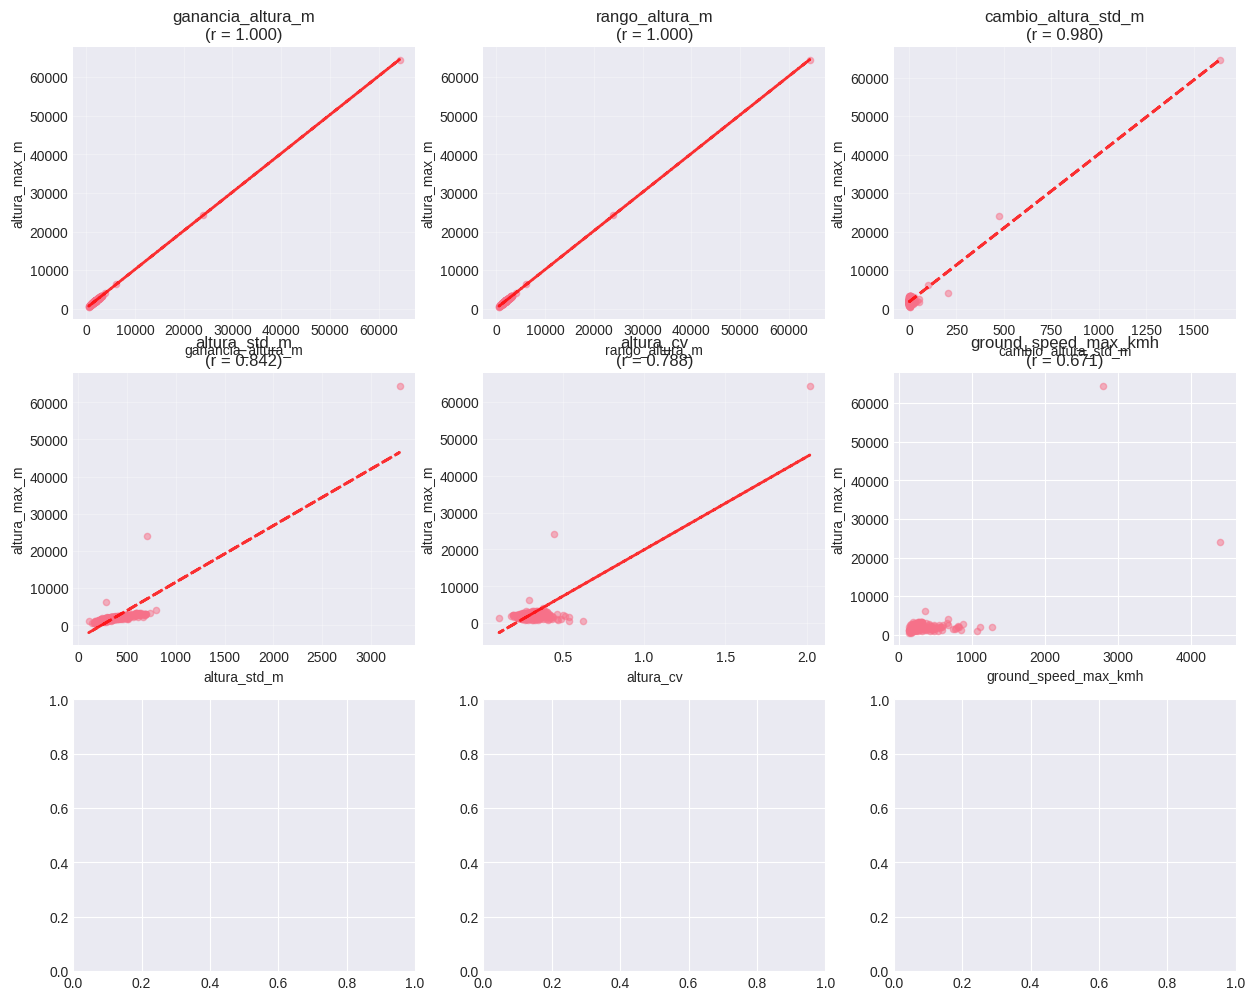

In [25]:
# Scatter plots de top features vs cada target
for target in targets_regresion:
    if target in df.columns:
        # Obtener top 9 features correlacionadas
        top_features = feature_importance[target]['top_absolute'].head(9).index.tolist()
        
        plot_scatter_matrix_with_target(
            df,
            target,
            top_features,
            save_path=f'{vis_dir}/08_scatter_{target}.png'
        )

---
## 9. Detección de Outliers

In [ ]:
# Analizar outliers en targets con múltiples métodos
print("="*70)
print("DETECCIÓN DE OUTLIERS EN TARGETS")
print("="*70)

for target in targets_regresion:
    if target in df.columns:
        print(f"\n{target}:")
        outliers = detect_outliers_multiple_methods(df, target)
        
        for method, info in outliers.items():
            print(f"  {method.upper()}:")
            print(f"    Outliers: {info['count']} ({info['percentage']:.2f}%)")
            if 'lower_bound' in info:
                print(f"    Bounds: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")

**Decisión sobre outliers:**
- NO eliminaremos outliers en targets (son vuelos reales extremos)
- Aplicaremos winsorización a features para reducir impacto de valores extremos

---
## 10. Comparación por Calidad de Día

In [ ]:
# Comparar features meteorológicas por calidad de día
features_comparar = [
    'temp_2m_max', 'solar_rad_max', 'cape_max',
    'boundary_layer_height_max', 'wind_speed_mean', 'cloud_cover_mean'
]
features_comparar = [f for f in features_comparar if f in df.columns]

plot_boxplots_by_class(
    df,
    features_comparar,
    target_clasificacion,
    save_path=f'{vis_dir}/09_comparacion_por_calidad.png',
    n_cols=3
)

---
## 11. Split Train/Val/Test (70/15/15)

In [ ]:
# Split estratificado en 3 conjuntos
print("="*70)
print("SPLIT ESTRATIFICADO TRAIN/VAL/TEST")
print("="*70)

train_df, val_df, test_df = split_train_val_test(
    df,
    stratify_col=target_clasificacion,
    train_size=0.70,
    val_size=0.15,
    test_size=0.15,
    random_state=42
)

print(f"\n✓ Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"✓ Val: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"✓ Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

In [ ]:
# Verificar estratificación
print("\nVerificación de estratificación:")
print("\nDistribución en TRAIN:")
print(train_df[target_clasificacion].value_counts(normalize=True).sort_index())
print("\nDistribución en VAL:")
print(val_df[target_clasificacion].value_counts(normalize=True).sort_index())
print("\nDistribución en TEST:")
print(test_df[target_clasificacion].value_counts(normalize=True).sort_index())

---
## 12. Preprocesamiento

In [ ]:
# Crear pipeline de preprocesamiento
preprocessor = PreprocessingPipeline()
print("✓ Pipeline de preprocesamiento creado")

### 12.1 Eliminar Features Inútiles

In [ ]:
# Eliminar features recomendadas
features_to_drop = useless_features['recommended_to_drop']
features_to_drop = [f for f in features_to_drop if f in train_df.columns]

print(f"Features a eliminar: {len(features_to_drop)}")
print(features_to_drop)

train_df = train_df.drop(columns=features_to_drop)
val_df = val_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)

print(f"\n✓ Train shape: {train_df.shape}")
print(f"✓ Val shape: {val_df.shape}")
print(f"✓ Test shape: {test_df.shape}")

### 12.2 Tratamiento de Valores Faltantes

In [ ]:
print("="*70)
print("IMPUTACIÓN DE VALORES FALTANTES")
print("="*70)
print("""
Estrategia:
1. Columnas con >50% faltantes → ELIMINAR
2. Numéricas → Mediana (robusta a outliers)
3. Categóricas → Moda
4. CRÍTICO: Ajustar solo con TRAIN
""")

# Aplicar a train y val
train_clean, val_clean, imputer_info = preprocessor.handle_missing_values(
    train_df.copy(),
    val_df.copy(),
    threshold=0.5
)

# Aplicar mismo tratamiento a test (usando mismos imputers)
test_clean = test_df.copy()
if imputer_info['dropped_columns']:
    test_clean = test_clean.drop(columns=[c for c in imputer_info['dropped_columns'] if c in test_clean.columns])

print(f"\n✓ Columnas eliminadas: {len(imputer_info['dropped_columns'])}")
print(f"✓ Valores imputados: {imputer_info['imputed_count']}")
print(f"\nShapes después de imputación:")
print(f"  Train: {train_clean.shape}")
print(f"  Val: {val_clean.shape}")
print(f"  Test: {test_clean.shape}")

### 12.3 Tratamiento de Outliers (Winsorización)

In [ ]:
print("="*70)
print("TRATAMIENTO DE OUTLIERS")
print("="*70)
print("""
Estrategia:
1. Método: Winsorización (capping)
2. Percentiles: 1% y 99%
3. NO eliminar observaciones
4. Ajustar bounds con TRAIN
""")

train_outliers, val_outliers, outlier_info = preprocessor.handle_outliers(
    train_clean.copy(),
    val_clean.copy(),
    method='winsorize',
    lower_percentile=0.01,
    upper_percentile=0.99
)

# Aplicar mismo tratamiento a test
test_outliers = test_clean.copy()
numeric_cols_test = test_outliers.select_dtypes(include=[np.number]).columns
for col in numeric_cols_test:
    if col in preprocessor.outlier_bounds:
        lower, upper = preprocessor.outlier_bounds[col]
        test_outliers[col] = test_outliers[col].clip(lower, upper)

print(f"\n✓ Features procesadas: {outlier_info['n_features']}")
print(f"✓ Valores modificados (train): {outlier_info['n_modified_train']}")
print(f"✓ Valores modificados (val): {outlier_info['n_modified_val']}")

### 12.4 Codificación de Variables Categóricas (OHE)

In [ ]:
print("="*70)
print("CODIFICACIÓN DE VARIABLES CATEGÓRICAS")
print("="*70)
print("""
Estrategia:
1. Método: One-Hot Encoding
2. Excluir: target de clasificación
3. Alinear columnas entre conjuntos
""")

# Identificar categóricas
cat_features = [col for col in train_outliers.select_dtypes(include=['object']).columns 
                if col != target_clasificacion]

print(f"\nCategóricas a codificar: {len(cat_features)}")
if len(cat_features) > 0:
    print(cat_features)

if len(cat_features) > 0:
    train_encoded, val_encoded, encoding_info = preprocessor.encode_categorical(
        train_outliers.copy(),
        val_outliers.copy(),
        categorical_features=cat_features,
        method='onehot'
    )
    
    # Aplicar a test
    test_encoded = pd.get_dummies(test_outliers, columns=cat_features, drop_first=True)
    # Alinear columnas
    for col in train_encoded.columns:
        if col not in test_encoded.columns:
            test_encoded[col] = 0
    test_encoded = test_encoded[train_encoded.columns]
    
    print(f"\n✓ Nuevas columnas creadas: {encoding_info['n_new_columns']}")
else:
    train_encoded = train_outliers.copy()
    val_encoded = val_outliers.copy()
    test_encoded = test_outliers.copy()
    print("\n✓ No hay variables categóricas para codificar")

print(f"\nShapes después de encoding:")
print(f"  Train: {train_encoded.shape}")
print(f"  Val: {val_encoded.shape}")
print(f"  Test: {test_encoded.shape}")

### 12.5 Normalización (RobustScaler)

In [ ]:
print("="*70)
print("NORMALIZACIÓN DE FEATURES")
print("="*70)
print("""
Estrategia:
1. Método: RobustScaler (robusto a outliers)
2. Excluir: targets, IDs, fechas
3. Ajustar con TRAIN, aplicar a todos
""")

# Identificar features a escalar
exclude_cols = ['fecha', target_clasificacion] + targets_regresion
exclude_cols = [col for col in exclude_cols if col in train_encoded.columns]

feature_cols = [col for col in train_encoded.columns if col not in exclude_cols]
numeric_features = train_encoded[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"\nFeatures numéricas a escalar: {len(numeric_features)}")

# Escalar
train_scaled, val_scaled, scaler = preprocessor.scale_features(
    train_encoded.copy(),
    val_encoded.copy(),
    features_to_scale=numeric_features,
    method='robust'
)

# Aplicar a test
test_scaled = test_encoded.copy()
test_scaled[numeric_features] = scaler.transform(test_scaled[numeric_features])

print(f"\n✓ Train: {train_scaled.shape}")
print(f"✓ Val: {val_scaled.shape}")
print(f"✓ Test: {test_scaled.shape}")

In [ ]:
# Verificar escalado
print("\nVerificación del escalado (primeras 5 features):")
for col in numeric_features[:5]:
    print(f"\n{col}:")
    print(f"  Train → Media: {train_scaled[col].mean():.4f}, Std: {train_scaled[col].std():.4f}")
    print(f"  Val   → Media: {val_scaled[col].mean():.4f}, Std: {val_scaled[col].std():.4f}")
    print(f"  Test  → Media: {test_scaled[col].mean():.4f}, Std: {test_scaled[col].std():.4f}")

---
## 13. Guardar Datasets Preprocesados

In [ ]:
# Guardar datasets
import os
os.makedirs('data/processed', exist_ok=True)

train_scaled.to_csv('data/processed/train_preprocessed.csv', index=False)
val_scaled.to_csv('data/processed/val_preprocessed.csv', index=False)
test_scaled.to_csv('data/processed/test_preprocessed.csv', index=False)

print("="*70)
print("DATASETS GUARDADOS")
print("="*70)
print(f"\n✓ Train: data/processed/train_preprocessed.csv")
print(f"  {train_scaled.shape[0]} filas × {train_scaled.shape[1]} columnas")
print(f"\n✓ Val: data/processed/val_preprocessed.csv")
print(f"  {val_scaled.shape[0]} filas × {val_scaled.shape[1]} columnas")
print(f"\n✓ Test: data/processed/test_preprocessed.csv")
print(f"  {test_scaled.shape[0]} filas × {test_scaled.shape[1]} columnas")

---
## 14. Resumen Final

In [ ]:
resumen = f"""
{'='*70}
RESUMEN COMPLETO - ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO
{'='*70}

DATASET ORIGINAL:
  • Total filas: {len(df)}
  • Total columnas: {len(df.columns)}
  • Features numéricas: {len(df.select_dtypes(include=[np.number]).columns)}
  • Features categóricas: {len(df.select_dtypes(include=['object']).columns)}

TARGETS:
  • Regresión: {', '.join(targets_regresion)}
  • Clasificación: {target_clasificacion}

DESBALANCEO DE CLASES:
  • Ratio: {balance_info['imbalance_ratio']:.2f}
  • Estado: {balance_info['balance_status']}

FEATURES ELIMINADAS:
  • IDs y constantes: {len(features_to_drop)}
  • Por valores faltantes: {len(imputer_info.get('dropped_columns', []))}
  • Total eliminadas: {len(features_to_drop) + len(imputer_info.get('dropped_columns', []))}

SPLIT DE DATOS:
  • Train: {len(train_scaled)} ({len(train_scaled)/len(df)*100:.1f}%)
  • Val: {len(val_scaled)} ({len(val_scaled)/len(df)*100:.1f}%)
  • Test: {len(test_scaled)} ({len(test_scaled)/len(df)*100:.1f}%)
  • Estratificación: {target_clasificacion}

PREPROCESAMIENTO APLICADO:

  1. Valores Faltantes:
     • Método: Mediana (numéricas), Moda (categóricas)
     • Columnas droppeadas: {len(imputer_info.get('dropped_columns', []))}
     • Valores imputados: {imputer_info.get('imputed_count', 0)}

  2. Outliers:
     • Método: Winsorización (percentiles 1-99)
     • Features procesadas: {outlier_info.get('n_features', 0)}
     • Valores modificados: {outlier_info.get('n_modified_train', 0)} (train)

  3. Codificación:
     • Variables categóricas: {len(cat_features)}
     • Método: One-Hot Encoding
     {'• Nuevas columnas: ' + str(encoding_info.get('n_new_columns', 0)) if len(cat_features) > 0 else ''}

  4. Normalización:
     • Método: RobustScaler
     • Features escaladas: {len(numeric_features)}

DATASETS FINALES:
  • Train: {train_scaled.shape[0]} × {train_scaled.shape[1]}
  • Val: {val_scaled.shape[0]} × {val_scaled.shape[1]}
  • Test: {test_scaled.shape[0]} × {test_scaled.shape[1]}

VISUALIZACIONES GENERADAS:
  • 9 archivos en /visualizaciones/
  • Distribuciones, correlaciones, outliers, comparaciones

GARANTÍAS DE CALIDAD:
  ✓ Sin data leakage (ajustes solo con train)
  ✓ Estratificación mantenida
  ✓ Proporciones verificadas
  ✓ Escalado verificado

PRÓXIMO PASO:
  → Feature Engineering (opcional)
  → Modelado y Evaluación
{'='*70}
"""

print(resumen)

# Guardar resumen
with open('data/processed/resumen_preprocesamiento.txt', 'w') as f:
    f.write(resumen)

print("\n✓ Resumen guardado: data/processed/resumen_preprocesamiento.txt")
print("\n✓✓✓ ANÁLISIS EXPLORATORIO Y PREPROCESAMIENTO COMPLETADO ✓✓✓")